In [2]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [3]:
import torch
import numpy as np
from torch import nn
from torch import Tensor
from torch.nn.functional import one_hot
from IPDL import TensorKernel, MatrixBasedRenyisEntropy, RKHSMatrixOptimizer, InformationPlane
from models import CNN, MLP
from matplotlib import pyplot as plt
from torchvision.transforms import Compose, ToTensor, ToPILImage, Normalize
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from tqdm import tqdm

In [4]:
net = CNN().cuda()

In [5]:
from torch.nn.functional import one_hot

transformToTensor = Compose([ ToTensor(), Normalize((0.1307,), (0.3081,))])
# transformToTensor = Compose([ ToTensor()])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [45000, 15000])
dataloader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=0)


# val_inputs = torch.load("tests/eval_inputs_0.pt").flatten(1).cuda()
# val_labels = torch.load("tests/eval_labels_0.pt").cuda()

val_inputs, val_labels = next(iter(dataloader_2))
# val_inputs = val_inputs.flatten(1).cuda()
val_inputs = val_inputs.cuda()
val_labels = val_labels.cuda()
val_labels = one_hot(val_labels, num_classes=10).float()

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs, val_labels)
        
    for inputs, labels in tqdm(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        # inputs = inputs.flatten(1).cuda()
        inputs = inputs.cuda()
        labels = labels.cuda()

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = net(inputs, one_hot(labels, num_classes=10).float())
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:    # print every 25 mini-batches
            loss_record.append(running_loss / 25)
            # print('[%d, %5d] loss: %.3f' %
            #     (epoch + 1, i + 1, running_loss / 25))
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs, val_labels)

        if i > 200:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(50)

        i += 1

print('Finished Training')

100%|██████████| 450/450 [01:47<00:00,  4.20it/s]Finished Training



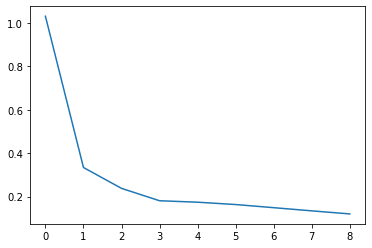

In [6]:
plt.plot(loss_record)
plt.show()

In [7]:
from utils import moving_average, showMutualInformation

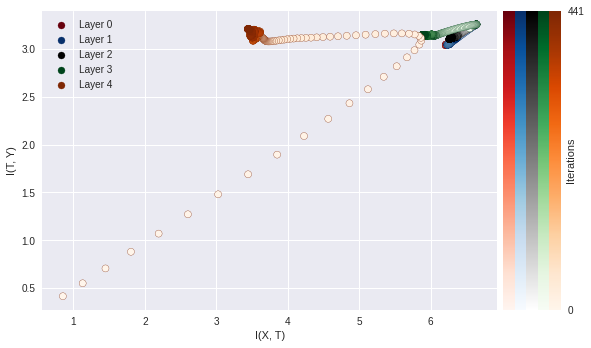

In [8]:
showMutualInformation(net)

In [9]:
def showMutualInformation(net):
    with plt.style.context('seaborn'):
        ips = net.getInformationPlaneLayers()
        colors = ['Reds', 'Blues', 'binary', 'Greens', 'Oranges']

        fig = plt.figure(constrained_layout=False)
        gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.84, wspace=0.05)
        gs2 = fig.add_gridspec(nrows=1, ncols=5, left=0.85, right=0.95, wspace=0)
        f8_ax1 = fig.add_subplot(gs1[:, :])
        f8_ax1.set_xlabel("I(X, T)")
        f8_ax1.set_ylabel("I(T, Y)")

        for idx, ip in enumerate(ips):
            cmap = plt.cm.get_cmap(colors[idx])
            Ixt, Ity = ip.getMutualInformation()
            Ixt = moving_average(Ixt)
            Ity = moving_average(Ity)
            iterations = np.arange(len(Ixt))
            color = np.array([cmap(iterations[-1])])
            sc = f8_ax1.scatter(Ixt, Ity, c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
            f8_ax1.scatter([], [], c=color, label="Layer {}".format(idx))

            f8_ax2 = fig.add_subplot(gs2[0, idx])
            cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
            cb.set_ticks([])

            if idx > 2:
                break

        f8_ax1.legend()
        cb.set_ticks([0, iterations.max()])
        cb.set_label("Iterations", labelpad=-18)

        plt.show()

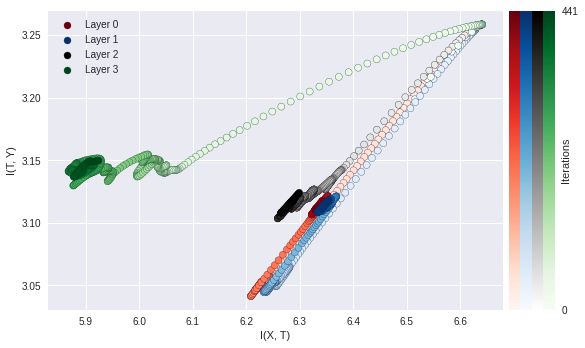

In [10]:
showMutualInformation(net)

# Test using MLP

In [11]:
net = MLP().cuda()

In [12]:
from torch.nn.functional import one_hot

# transformToTensor = Compose([ ToTensor(), Normalize((0.1307,), (0.3081,))])
transformToTensor = Compose([ ToTensor() ])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [45000, 15000])
dataloader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=0)


# val_inputs = torch.load("tests/eval_inputs_0.pt").flatten(1).cuda()
# val_labels = torch.load("tests/eval_labels_0.pt").cuda()

val_inputs, val_labels = next(iter(dataloader_2))
val_inputs = val_inputs.flatten(1).cuda()
val_labels = val_labels.cuda()
val_labels = one_hot(val_labels, num_classes=10).float()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs, val_labels)
        
    for inputs, labels in tqdm(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = inputs.flatten(1).cuda()
        labels = labels.cuda()

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:    # print every 25 mini-batches
            loss_record.append(running_loss / 25)
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs, val_labels)

        if i > 200:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(100)

        i += 1

print('Finished Training')

100%|██████████| 450/450 [01:59<00:00,  3.78it/s]Finished Training



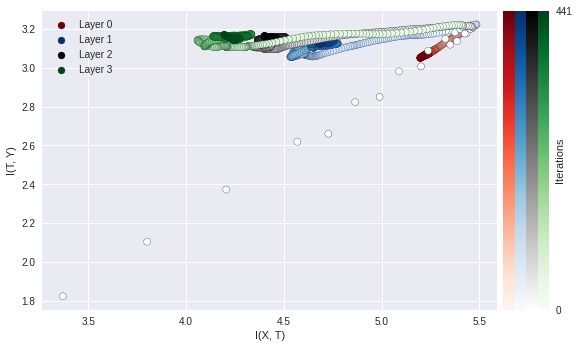

In [13]:
showMutualInformation(net)

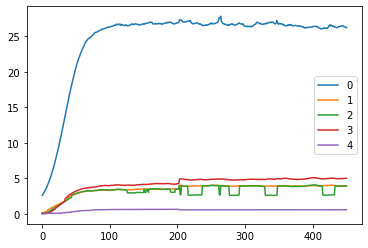

In [23]:
ips = net.getInformationPlaneLayers()
for i, ip in enumerate(ips):
    plt.plot(ip.sigma_optimizer.getSigmaValues(), label=i)

plt.legend()
plt.show()